In [1]:
from simulator import Sim
from strategy import BestPosStrategy
from get_info import get_pnl
from load_data import load_md_from_file


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

PATH_TO_FILE = '../md/btcusdt:Binance:LinearPerpetual/'
NROWS = 2000

In [2]:
md = load_md_from_file(path=PATH_TO_FILE, nrows=NROWS)

In [3]:
trades = pd.read_csv(PATH_TO_FILE+'trades.csv', nrows=100000)

In [4]:
trades.head(20)

,receive_ts,exchange_ts,aggro_side,price,size
0,1655942402624789714,1655942402623000000,BID,19977.5,0.001
1,1655942405293556247,1655942405292000000,BID,19977.5,0.041
2,1655942405293628020,1655942405292000000,BID,19977.5,0.036
3,1655942405293832021,1655942405292000000,BID,19977.5,0.001
4,1655942405293929517,1655942405292000000,BID,19977.5,0.001
5,1655942405294003345,1655942405292000000,BID,19977.8,0.003
6,1655942405294140676,1655942405292000000,BID,19977.9,0.003
7,1655942405294206928,1655942405292000000,BID,19978.0,0.001
8,1655942408891268324,1655942408890000000,ASK,19977.9,0.020
9,1655942409197011118,1655942409193000000,BID,19978.0,0.058


In [5]:
len(set(trades.exchange_ts))

35350

In [6]:
len(set(trades.receive_ts))

100000

In [7]:
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

sim = Sim(md, latency, md_latency)

In [8]:
#delay between orders
delay = pd.Timedelta(0.1, 's').delta

hold_time = pd.Timedelta(10, 's').delta

strategy = BestPosStrategy(delay, hold_time)

In [9]:
trades_list, md_list, updates_list = strategy.run(sim)

In [10]:
df = get_pnl(updates_list)

In [11]:
dt = pd.to_datetime(df.receive_ts)

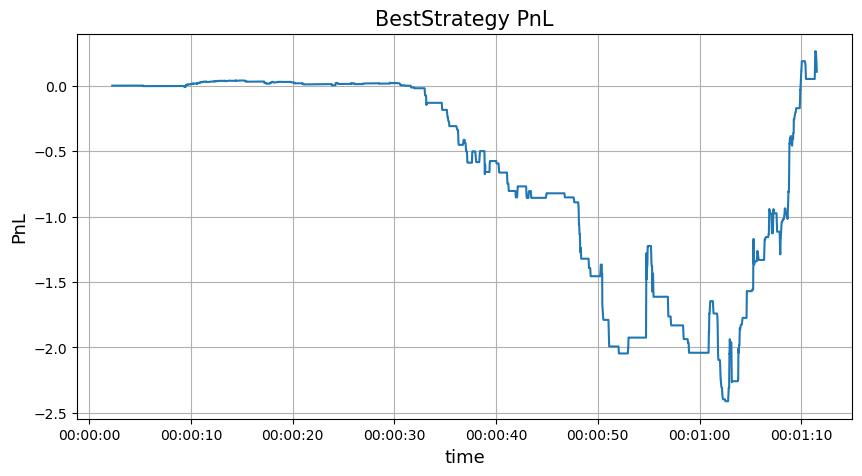

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(dt, df.total, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("BestStrategy PnL", fontsize=15)
plt.grid()
plt.show()

In [13]:
from simulator import Sim
from strategy import BestPosStrategy
from get_info import get_pnl
from load_data import load_md_from_file


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [14]:
from simulator import MdUpdate, OrderbookSnapshotUpdate, AnonTrade

from get_info import md_to_dataframe, trade_to_dataframe

In [15]:
def generate_sample_data_1(n_points):
    mid_price = 100.0
    spread = 2.0
    bid_price = mid_price - spread / 2
    ask_price = mid_price + spread / 2
    size = 1
    
    order_books_md = [ MdUpdate(i, i, OrderbookSnapshotUpdate(i, i, [(ask_price, size)], [(bid_price, size)]), None)
                     for i in range(n_points) ]
    
    
    trades = []
    p = 0.25
    trade_id = np.random.choice([0, 1], size=n_points, p=[1-p, p])
    for i in range(n_points):
        
        if trade_id[i]:
            
            side = np.random.choice([0, 1], size=1)[0]
            price = bid_price if side else ask_price
            side = "ASK" if side else "BID" 
            trade = AnonTrade(i, i, side, size, price)
            trades.append(trade)

    return order_books_md, trades

In [16]:
def generate_sample_data_2(n_points):
    
    mid_price = 100.0
    spread = 2.0
    bid_price = mid_price - spread / 2
    ask_price = mid_price + spread / 2
    size = 1
    
    order_books_md = []
    
    
    trades = []
    p = 0.5
    trade_id = np.random.choice([0, 1], size=n_points, p=[1-p, p])
    trade_id = [i % 4 == 0 for i in range(n_points)]
    for i in range(n_points):
        
        bid_price = mid_price - spread / 2
        ask_price = mid_price + spread / 2
        
        order_book = OrderbookSnapshotUpdate(i, i, [(ask_price, size)], [(bid_price, size)])
        order_books_md.append( MdUpdate(i, i, order_book, None)  )

        if trade_id[i]:
            side = np.random.choice([0, 1], size=1)[0]
            side = i % 2
            price = bid_price if side else ask_price
            side = "ASK" if side else "BID" 
            trade = AnonTrade(i, i, side, size, price)
            trades.append(trade)
        
        mid_price += 5
    return order_books_md, trades

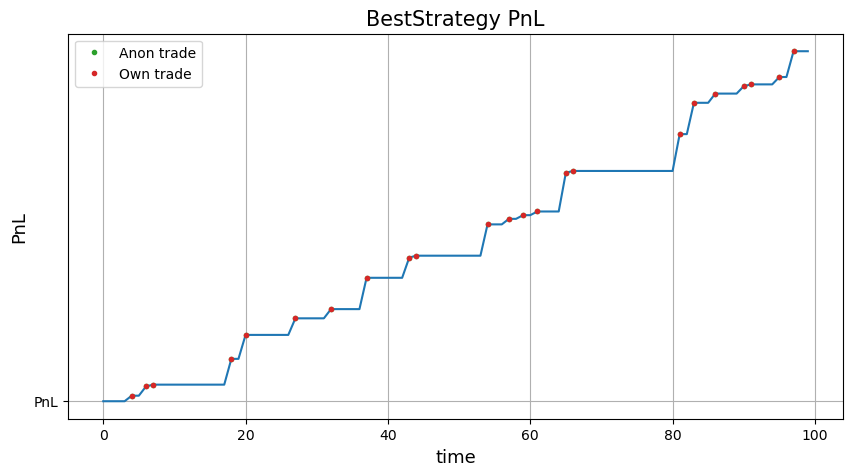

In [17]:
order_books_md, anon_trades = generate_sample_data_1(100)

#prepare MD
trades_md = [ MdUpdate(trade.exchange_ts, trade.receive_ts, None, trade ) for trade in anon_trades ]
md = order_books_md + trades_md
md = sorted(md, key = lambda x: x.exchange_ts)

latency = pd.Timedelta(0, 'ns').delta
md_latency = pd.Timedelta(0, 'ns').delta
sim = Sim(md, latency, md_latency)

#delay between orders
delay = pd.Timedelta(1, 'ns').delta
hold_time = pd.Timedelta(1000, 'ns').delta
strategy = BestPosStrategy(delay, hold_time)

own_trades, md_list, updates_list = strategy.run(sim)


df_own_trades = trade_to_dataframe(own_trades)
df_anon_trades = trade_to_dataframe(anon_trades)

df_info = get_pnl(updates_list)
t = df_info.receive_ts.values

plt.figure(figsize=(10, 5))
plt.plot(t, df_info.total, '-', 'PnL')
plt.plot(df_anon_trades.receive_ts, df_info.total[  df_anon_trades.receive_ts.values  ], '.', label='Anon trade')
plt.plot(df_own_trades.receive_ts, df_info.total[  df_own_trades.receive_ts.values  ], '.', label='Own trade')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.legend()

plt.title("BestStrategy PnL", fontsize=15)
plt.grid()
plt.show()

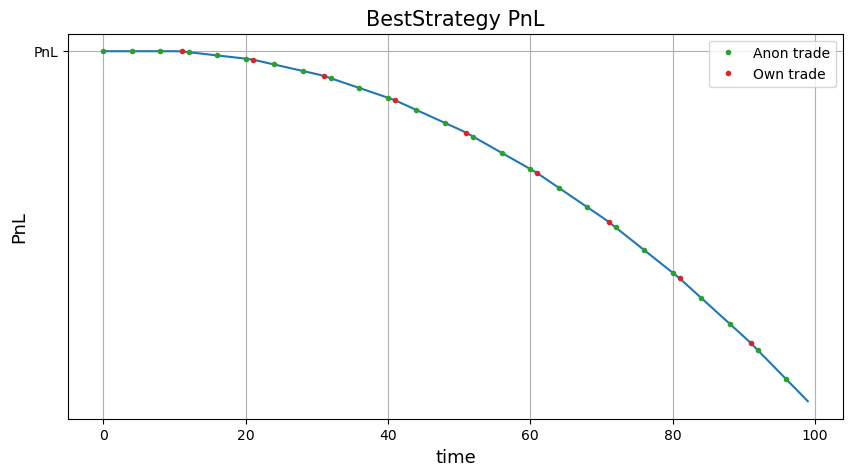

In [18]:
order_books_md, anon_trades = generate_sample_data_2(100)

#prepare MD
trades_md = [ MdUpdate(trade.exchange_ts, trade.receive_ts, None, trade ) for trade in anon_trades ]
md = order_books_md + trades_md
md = sorted(md, key = lambda x: x.exchange_ts)

latency = pd.Timedelta(0, 'ns').delta
md_latency = pd.Timedelta(0, 'ns').delta
sim = Sim(md, latency, md_latency)

#delay between orders
delay = pd.Timedelta(10, 'ns').delta
hold_time = pd.Timedelta(1000, 'ns').delta
strategy = BestPosStrategy(delay, hold_time)

own_trades, md_list, updates_list = strategy.run(sim)


df_own_trades = trade_to_dataframe(own_trades)
df_anon_trades = trade_to_dataframe(anon_trades)

df_info = get_pnl(updates_list)
t = df_info.receive_ts.values

plt.figure(figsize=(10, 5))
plt.plot(t, df_info.total, '-', 'PnL')
plt.plot(df_anon_trades.receive_ts, df_info.total[  df_anon_trades.receive_ts.values  ], '.', label='Anon trade')
plt.plot(df_own_trades.receive_ts, df_info.total[  df_own_trades.receive_ts.values  ], '.', label='Own trade')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.legend()

plt.title("BestStrategy PnL", fontsize=15)
plt.grid()
plt.show()